In [1]:
!pip install -r requirements.txt

# Data Visualization

Total Entities: 360

type
Attraction    150
Hotel         100
Activity      100
City           10
Name: count, dtype: int64 

Entities per City:
 city
Hanoi               35
Ha Long Bay         35
Sapa                35
Hue                 35
Hoi An              35
Da Nang             35
Nha Trang           35
Da Lat              35
Ho Chi Minh City    35
Mekong Delta        35
Name: count, dtype: int64 

Top 10 Tags:
stay: 100
experience: 100
beach: 33
romantic: 29
mountain: 25
history: 21
resort: 21
heritage: 18
food: 16
imperial: 16

Entities per Region (Cities Only):
 region
Southern Vietnam    4
Northern Vietnam    3
Central Vietnam     3
Name: count, dtype: int64


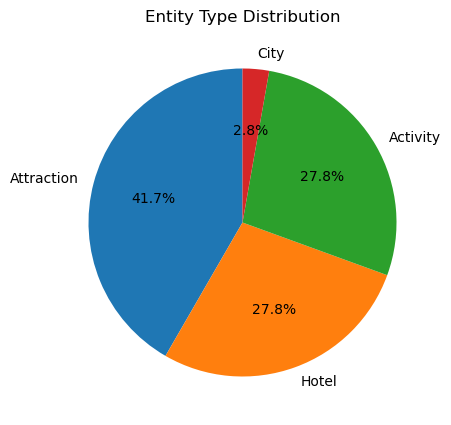

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load dataset
with open("vietnam_travel_dataset.json") as f:
    data = json.load(f)
df = pd.DataFrame(data)

# --- Summary Stats ---
print(f"Total Entities: {len(df)}\n")
print(df["type"].value_counts(), "\n")
print("Entities per City:\n", df["city"].value_counts(), "\n")
tags = [t for tags in df["tags"].dropna() for t in tags]
print("Top 10 Tags:")
for tag, c in Counter(tags).most_common(10): print(f"{tag}: {c}")
print("\nEntities per Region (Cities Only):\n", df[df["type"]=="City"]["region"].value_counts())

# --- Visuals ---
plt.figure(figsize=(5,5))
df["type"].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, title="Entity Type Distribution")
plt.ylabel("")
plt.show()

# Pinecone_Upload

In [3]:
import json
import time
import torch
from tqdm import tqdm
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
import config

# -----------------------------
# Config
# -----------------------------
DATA_FILE = "vietnam_travel_dataset.json"
BATCH_SIZE = 32

INDEX_NAME = config.PINECONE_INDEX_NAME
VECTOR_DIM = config.PINECONE_VECTOR_DIM  

# -----------------------------
# Initialize clients
# -----------------------------
pc = Pinecone(api_key=config.PINECONE_API_KEY)

# -----------------------------
# Create managed index if it doesn't exist
# -----------------------------
existing_indexes = pc.list_indexes().names()
if INDEX_NAME not in existing_indexes:
    print(f"Creating managed index: {INDEX_NAME}")
    pc.create_index(
        name=INDEX_NAME,
        dimension=VECTOR_DIM,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
else:
    print(f"Index {INDEX_NAME} already exists.")

index = pc.Index(INDEX_NAME)

# -----------------------------
# Embedding model
# -----------------------------
model = SentenceTransformer("all-MiniLM-L6-v2")  # 384-dim

def get_embeddings(texts, model):
    """Generate embeddings locally using SentenceTransformer."""
    with torch.no_grad():
        embeddings = model.encode(texts, show_progress_bar=False, convert_to_numpy=True)
    return embeddings.tolist()

def chunked(iterable, n):
    for i in range(0, len(iterable), n):
        yield iterable[i:i+n]

# -----------------------------
# Main upload
# -----------------------------
def main():
    with open(DATA_FILE, "r", encoding="utf-8") as f:
        nodes = json.load(f)

    items = []
    for node in nodes:
        semantic_text = node.get("semantic_text") or (node.get("description") or "")[:1000]
        if not semantic_text.strip():
            continue
        meta = {
            "id": node.get("id"),
            "type": node.get("type"),
            "name": node.get("name"),
            "city": node.get("city", node.get("region", "")),
            "tags": node.get("tags", [])
        }
        items.append((node["id"], semantic_text, meta))

    print(f"Preparing to upsert {len(items)} items to Pinecone...")

    for batch in tqdm(list(chunked(items, BATCH_SIZE)), desc="Uploading batches"):
        ids = [item[0] for item in batch]
        texts = [item[1] for item in batch]
        metas = [item[2] for item in batch]

        embeddings = get_embeddings(texts, model)
        vectors = [{"id": _id, "values": emb, "metadata": meta}
                   for _id, emb, meta in zip(ids, embeddings, metas)]

        index.upsert(vectors)
        time.sleep(0.2)

    print("All items uploaded successfully.")

# -----------------------------
if __name__ == "__main__":
    main()


Creating managed index: vietnam-travel
Preparing to upsert 360 items to Pinecone...


Uploading batches: 100%|███████████████████| 12/12 [00:26<00:00,  2.17s/it]

All items uploaded successfully.


# Test_Hybrid

In [10]:
import json
from typing import List
from pinecone import Pinecone, ServerlessSpec
from neo4j import GraphDatabase
from sentence_transformers import SentenceTransformer
import google.generativeai as genai
from requests.exceptions import ReadTimeout, ConnectionError
import time, sys
import config
import os


# -----------------------------
# Config
# -----------------------------
EMBED_MODEL = "all-MiniLM-L6-v2"      
TOP_K = 5
INDEX_NAME = config.PINECONE_INDEX_NAME
DATASET_FILE = "vietnam_travel_dataset.json"

# -----------------------------
# Initialize Gemini, Pinecone, Neo4j
# -----------------------------
genai.configure(api_key=config.GEMINI_API_KEY)
pc = Pinecone(api_key=config.PINECONE_API_KEY)

# --- Safe model load with retries ---
for attempt in range(3):
    try:
        print(f"[INIT] Loading embedding model ({EMBED_MODEL})… attempt {attempt+1}")
        model = SentenceTransformer(EMBED_MODEL)
        print("[INIT] Model loaded successfully.\n")
        break
    except (ReadTimeout, ConnectionError) as e:
        print(f"[WARN] Network timeout while loading model: {e}")
        if attempt < 2:
            print("Retrying in 5 seconds…\n")
            time.sleep(5)
        else:
            print("[ERROR] Could not download model after 3 tries. "
                  "Please check your internet connection or Hugging Face availability.")
            sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected error while loading model: {e}")
        sys.exit(1)


# List indexes safely and check correctly
try:
    indexes = pc.list_indexes()
    index_names = indexes.get("names", indexes) if isinstance(indexes, dict) else indexes

    if INDEX_NAME not in index_names:
        print(f"[INIT] Creating new Pinecone index: {INDEX_NAME}")
        pc.create_index(
            name=INDEX_NAME,
            dimension=config.PINECONE_VECTOR_DIM,
            metric="cosine",
            spec=ServerlessSpec(cloud="aws", region=config.PINECONE_ENV)
        )
    else:
        print(f"[INIT] Using existing Pinecone index: {INDEX_NAME}")
except Exception as e:
    print(f"[WARN] Index already created before: {e}")

index = pc.Index(INDEX_NAME)

# Connect to Neo4j
driver = GraphDatabase.driver(
    config.NEO4J_URI,
    auth=(config.NEO4J_USER, config.NEO4J_PASSWORD)
)

# Load optional dataset
local_dataset = {}
if os.path.exists(DATASET_FILE):
    try:
        with open(DATASET_FILE, "r", encoding="utf-8") as f:
            data = json.load(f)
            local_dataset = {item["id"]: item for item in data}
            print(f"[INIT] Loaded dataset with {len(local_dataset)} entries.")
    except Exception as e:
        print(f"[WARN] Could not load dataset: {e}")

# -----------------------------
# Helper functions
# -----------------------------
def embed_text(text: str) -> List[float]:
    """Convert text into embedding vector."""
    return model.encode([text], convert_to_numpy=True)[0].tolist()


def pinecone_query(query_text: str, top_k=TOP_K):
    """Retrieve top-K semantic matches from Pinecone."""
    try:
        vec = embed_text(query_text)
        res = index.query(vector=vec, top_k=top_k, include_metadata=True)
        return res.get("matches", [])
    except Exception as e:
        print(f"[ERROR] Pinecone query failed: {e}")
        return []


def fetch_graph_context(node_ids: List[str]):
    """Fetch related graph entities from Neo4j."""
    facts = []
    if not node_ids:
        return facts
    with driver.session() as session:
        q = (
            "MATCH (n:Entity)-[r]-(m:Entity) "
            "WHERE n.id IN $ids "
            "RETURN n.id AS source, type(r) AS rel, "
            "m.id AS target_id, m.name AS name, m.description AS description "
            "LIMIT 40"
        )
        recs = session.run(q, ids=node_ids)
        for r in recs:
            facts.append({
                "source": r["source"],
                "rel": r["rel"],
                "target_id": r["target_id"],
                "target_name": r["name"],
                "target_desc": (r["description"] or "")[:200]
            })
    return facts


def detect_query_type(query: str) -> str:
    """Detect user query type to control style/temperature."""
    q = query.lower()
    if any(k in q for k in ["plan", "itinerary", "route", "trip", "days"]):
        return "itinerary"
    if any(k in q for k in ["hotel", "stay", "accommodation"]):
        return "hotel"
    if any(k in q for k in ["food", "eat", "cuisine", "restaurant"]):
        return "food"
    if any(k in q for k in ["activity", "things to do", "experience"]):
        return "activity"
    if any(k in q for k in ["best time", "weather", "season"]):
        return "timing"
    return "general"


def build_prompt(user_query, pinecone_matches, graph_facts):
    """Enhanced structured prompt with few-shot examples for Gemini travel assistant."""

    # --- Group matches by type ---
    grouped = {"City": [], "Attraction": [], "Hotel": [], "Activity": [], "Other": []}
    for m in pinecone_matches:
        t = m["metadata"].get("type", "Other")
        grouped.setdefault(t, []).append(m)

    def format_group(title, items):
        if not items:
            return ""
        lines = []
        for m in items:
            meta = m["metadata"]
            node_id = m["id"]
            name = meta.get("name", "")
            city = meta.get("city", "Unknown")
            node_type = meta.get("type", "")
            # add best time if available in local dataset
            best_time = ""
            if node_id in local_dataset and "best_time_to_visit" in local_dataset[node_id]:
                best_time = f", Best time: {local_dataset[node_id]['best_time_to_visit']}"
            lines.append(f"- [{node_id}] {name} ({node_type}, {city}{best_time})")
        return f"\n### {title}\n" + "\n".join(lines)

    vec_context = (
        format_group("Cities", grouped["City"]) +
        format_group("Attractions", grouped["Attraction"]) +
        format_group("Hotels", grouped["Hotel"]) +
        format_group("Activities", grouped["Activity"])
    )

    graph_context = "\n".join([
        f"- {f['source']} -[{f['rel']}]-> {f['target_name']} ({f['target_id']})"
        for f in graph_facts
    ])

    # Few-shot examples (to guide Gemini style)
    examples = """
### Example 1:
*User Query:* I love beaches and nature. What places should I visit in Vietnam?

*Assistant Response:*
You’ll enjoy [city_ha_long] and [city_da_nang], both known for beaches and nature.
- Start at Ha Long Bay for cruises and limestone islands ([attraction_36], [attraction_50]).
- Then explore Da Nang’s coastal views and stay at [hotel_54] or [hotel_58].
- Ideal travel months: February–May.

---

### Example 2:
*User Query:* I want a cultural trip with heritage and food in Northern Vietnam.

*Assistant Response:*
Focus on [city_hanoi] and [city_sapa].
- Visit the Old Quarter and street markets in Hanoi ([attraction_3], [activity_27]).
- Trek through Sapa’s ethnic villages and stay at [hotel_86].
- Best time to visit: October–April.
"""

    # Core prompt
    prompt = f"""
You are *VietTravel AI*, an expert travel planner for Vietnam.
You combine *semantic matches (Pinecone)* and *graph relationships (Neo4j)* to give concise, itinerary-style travel recommendations.

### Instructions:
1. Use the context below to ground your answer.
2. Suggest *2–3 travel ideas or itinerary steps*.
3. Cite *node IDs* (e.g., [city_hanoi], [attraction_3]) when naming places.
4. Prefer nearby or connected destinations using graph facts.
5. Format the answer clearly with bullet points or short sections.
6. Keep answers under 6 sentences — practical, helpful, concise.

### User Query:
{user_query}

### Semantic Matches:
{vec_context}

### Graph Facts:
{graph_context}

{examples}

### Now respond helpfully and concisely below:
Answer:
"""
    return prompt.strip()


def call_chat(prompt_text: str, temperature: float = 0.2):
    """Send prompt to Gemini API and return generated text."""
    try:
        model_gemini = genai.GenerativeModel("gemini-2.0-flash")
        response = model_gemini.generate_content(
            prompt_text,
            generation_config=genai.GenerationConfig(
                temperature=temperature,
                max_output_tokens=600
            )
        )
        return response.text.strip()
    except Exception as e:
        return f"[ERROR] Gemini API call failed: {e}"


# -----------------------------
# Interactive Chat Loop
# -----------------------------
def interactive_chat():
    print("Hi, I am your Vietnam Travel Assistant")
    print("Type 'exit' to quit.\n")

    while True:
        q = input("Ask about your travel plans in Vietnam: ").strip()
        if not q:
            continue
        if q.lower() in ["exit", "quit"]:
            break

        qtype = detect_query_type(q)
        temp_map = {
            "itinerary": 0.25,
            "hotel": 0.2,
            "activity": 0.3,
            "food": 0.35,
            "timing": 0.15,
            "general": 0.2
        }
        temperature = temp_map.get(qtype, 0.2)

        matches = pinecone_query(q)
        graph_facts = fetch_graph_context([m["id"] for m in matches])

        prompt_text = build_prompt(q, matches, graph_facts)
        print("\n=== Response ===\n")
        print(call_chat(prompt_text, temperature))
        print("\n=======================\n")


# -----------------------------
# Run main
# -----------------------------
if __name__ == "__main__":
    interactive_chat()


[INIT] Loading embedding model (all-MiniLM-L6-v2)… attempt 1
[INIT] Model loaded successfully.

[INIT] Creating new Pinecone index: vietnam-travel
[WARN] Index already created before: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2024-04', 'x-cloud-trace-context': '60941b9c5eba128bcd3640fa6be96644', 'date': 'Mon, 20 Oct 2025 16:25:06 GMT', 'server': 'Google Frontend', 'Content-Length': '85', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"ALREADY_EXISTS","message":"Resource  already exists"},"status":409}

[INIT] Loaded dataset with 360 entries.
Hi, I am your Vietnam Travel Assistant
Type 'exit' to quit.



Ask about your travel plans in Vietnam:  What are the best beach cities in Vietnam?



=== Response ===

For beach destinations in Vietnam, consider these options:
- **Da Nang [city_da_nang]:** A coastal city in Central Vietnam known for its beaches. The best time to visit is year-round.
- **Ha Long Bay [city_ha_long]:** While famous for its bay, it also offers beach areas and is connected to other destinations like Hoi An [city_hoi_an]. Ideal time to visit is February to May.




Ask about your travel plans in Vietnam:  What can I explore around Da Nang in two days?



=== Response ===

In Da Nang, explore local attractions and nearby areas:
- Discover Da Nang's local attractions like [attraction_178], [attraction_181], and [attraction_189].
- Visit [attraction_190] and [attraction_176] to experience more of Da Nang.
- Consider a day trip to nearby Hoi An for its historic architecture.




Ask about your travel plans in Vietnam:  Recommend budget-friendly stays in Da Nang.



=== Response ===

Here are some budget-friendly hotel options in [city_da_nang]:
- Consider [hotel_191], [hotel_195], or [hotel_198] for affordable stays.
- These hotels are all located within Da Nang.
- Check online travel agencies for the best deals.




Ask about your travel plans in Vietnam:  exit
